# Transformer Example

### Importing necessary libraries

In [18]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import math

### Load and preprocess the data

In [19]:
# Load the data and parse the 'Timestamp' column explicitly
data = pd.read_csv(
    '/Users/casper/Documents/GitHub/p9-energy/Examples/test-data/maj2023_2024.csv', sep=';')

# Convert 'Timestamp' column to datetime format
data['Timestamp'] = pd.to_datetime(
data['Timestamp'], format='%d.%m.%Y %H.%M.%S')

# Split data into training (2023) and evaluation (2024) sets
train_data = data[data['Timestamp'].dt.year == 2023]
eval_data = data[data['Timestamp'].dt.year == 2024]

# Convert usage to numpy arrays
train_usage = train_data['Usage'].values.reshape(-1, 1)
eval_usage = eval_data['Usage'].values.reshape(-1, 1)

# Normalize the usage
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_usage)
eval_scaled = scaler.transform(eval_usage)

### Prepare sequences for the Transformer model

In [20]:
# Function to create sequences for Transformer model
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)


# Sequence length
seq_length = 192

# Create training and evaluation sequences
train_sequences = create_sequences(train_scaled, seq_length)
eval_sequences = create_sequences(eval_scaled, seq_length)

# Convert to NumPy arrays and then tensors
train_x, train_y = zip(*train_sequences)
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Convert eval data
eval_x, eval_y = zip(*eval_sequences)
eval_x = np.array(eval_x)
eval_y = np.array(eval_y)
eval_x = torch.tensor(eval_x, dtype=torch.float32)
eval_y = torch.tensor(eval_y, dtype=torch.float32)

### Define the Transformer model and positional encoding

In [21]:
# Positional encoding for the Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=64, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer model definition


class TransformerModel(nn.Module):
    def __init__(self, input_size=1, num_heads=8, hidden_size=200, num_layers=10):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Linear layer to project input to hidden_size
        self.input_projection = nn.Linear(input_size, hidden_size)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)

        # Fully connected layer to map transformer outputs to final prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Project input to hidden size
        x = self.input_projection(x)

        # Pass through transformer encoder
        out = self.transformer_encoder(x)

        # Take the output of the last time step
        out = self.fc(out[:, -1, :])  # Shape: (batch_size, 1)
        return out

### Initialize model, loss, optimizer, and TensorBoard

In [22]:
# Use MPS for Mac M1
device = torch.device('mps')

# Initialize the model
model = TransformerModel().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='runs/transformer_experiment')

### Training loop

In [23]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    start_time = time.time()

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    train_time = time.time() - start_time

    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)

    print(
        f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Time: {train_time:.2f}s')

# Close the writer after training
writer.close()

Epoch [1/1000], Loss: 0.0804, Time: 12.38s
Epoch [2/1000], Loss: 0.0186, Time: 9.12s
Epoch [3/1000], Loss: 0.0429, Time: 9.12s
Epoch [4/1000], Loss: 0.0350, Time: 22.14s
Epoch [5/1000], Loss: 0.0462, Time: 9.10s
Epoch [6/1000], Loss: 0.0407, Time: 8.72s
Epoch [7/1000], Loss: 0.0188, Time: 9.13s
Epoch [8/1000], Loss: 0.0174, Time: 8.81s
Epoch [9/1000], Loss: 0.0749, Time: 8.61s
Epoch [10/1000], Loss: 0.0337, Time: 8.64s
Epoch [11/1000], Loss: 0.0763, Time: 10.05s
Epoch [12/1000], Loss: 0.0098, Time: 11.06s
Epoch [13/1000], Loss: 0.0358, Time: 8.72s
Epoch [14/1000], Loss: 0.0681, Time: 8.56s
Epoch [15/1000], Loss: 0.0066, Time: 8.15s
Epoch [16/1000], Loss: 0.0343, Time: 8.89s
Epoch [17/1000], Loss: 0.0329, Time: 8.31s
Epoch [18/1000], Loss: 0.0123, Time: 7.97s
Epoch [19/1000], Loss: 0.0142, Time: 8.04s
Epoch [20/1000], Loss: 0.0048, Time: 8.55s
Epoch [21/1000], Loss: 0.0156, Time: 8.21s
Epoch [22/1000], Loss: 0.0190, Time: 7.94s
Epoch [23/1000], Loss: 0.0135, Time: 7.92s
Epoch [24/1000],

### Evaluate the model

In [26]:
# Evaluate on May 2024
model.eval()
with torch.no_grad():
    eval_x = eval_x.to(device)
    predictions = model(eval_x).cpu()

# Inverse scale predictions
predictions = scaler.inverse_transform(predictions.numpy())

# Compare predictions with actual usage
actual_usage = scaler.inverse_transform(eval_y.numpy())

# Convert actual usage to tensor
actual_tensor = torch.tensor(actual_usage, dtype=torch.float32)

# Calculate MSE using PyTorch
eval_loss = criterion(torch.tensor(
    predictions, dtype=torch.float32), actual_tensor)

print(f'Evaluation MSE Loss: {eval_loss.item():.4f}')

Evaluation MSE Loss: 0.3058


### Plot predictions vs actual usage

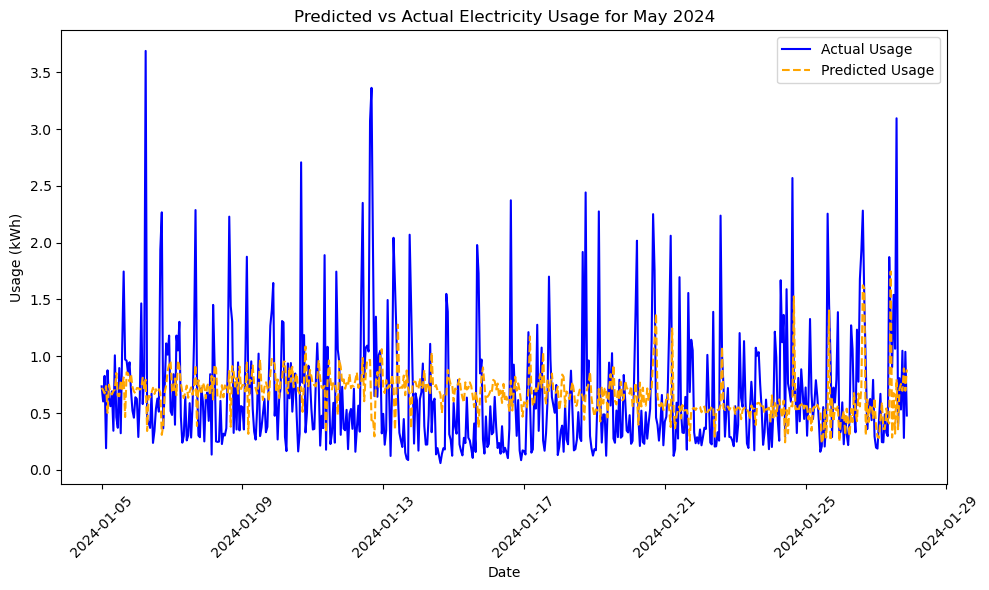

In [25]:
# Plot the actual vs predicted usage
date_range = pd.date_range(
    start='01.05.2024', periods=len(actual_usage), freq='h')

plt.figure(figsize=(10, 6))
plt.plot(date_range, actual_usage, label='Actual Usage', color='blue')
plt.plot(date_range, predictions, label='Predicted Usage',
         color='orange', linestyle='--')
plt.title('Predicted vs Actual Electricity Usage for May 2024')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()